In [5]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ProxNest as pxn



In [2]:
path_model = '/disk/xray0/tl3/repos/lexci_models/DnCNN/snr_15_model.pb'


In [3]:

tf_model = tf.saved_model.load(path_model)


2023-06-16 09:14:37.734522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 09:14:38.218747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


In [47]:

# Load Image
dim = 64
ground_truth = np.load('/disk/xray0/tl3/repos/proxnest/data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

# A simple identity forward model
phi = pxn.operators.sensing_operators.Identity()

# A wavelet dictionary in which we can promote sparsity
psi = pxn.operators.wavelet_operators.db_wavelets(["db6"], 2, (dim, dim))

# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(ground_truth)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, ground_truth.shape)

# Simulate mock noisy observations
y = phi.dir_op(ground_truth) + n


In [48]:


def dncnn_denoise(noisy_img):
    """Apply DnCNN denoising
    """
    # Convert to tensor with correct dtype
    tf_noisy_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
    # Add requried dimensions [Batch, Im_x, Im_y, C]
    tf_noisy_img = tf_noisy_img[np.newaxis,...,np.newaxis]
    # Denoise
    tf_denoised_img = tf_model(tf_noisy_img)
    # Remove extra dimensions and convert to numpy
    return tf.squeeze(tf_denoised_img).numpy()


In [50]:

np_denoised_y = dncnn_denoise(y)

In [30]:

tf_y = tf.convert_to_tensor(y, dtype=tf.float32)
tf_y = tf_y[np.newaxis,...,np.newaxis]


denoised_y = tf_model(tf_y)#, False, sigma)

denoised_y = tf.squeeze(denoised_y)
# denoised_y.shape

np_denoised_y = denoised_y.numpy()


TensorShape([1, 64, 64, 1])

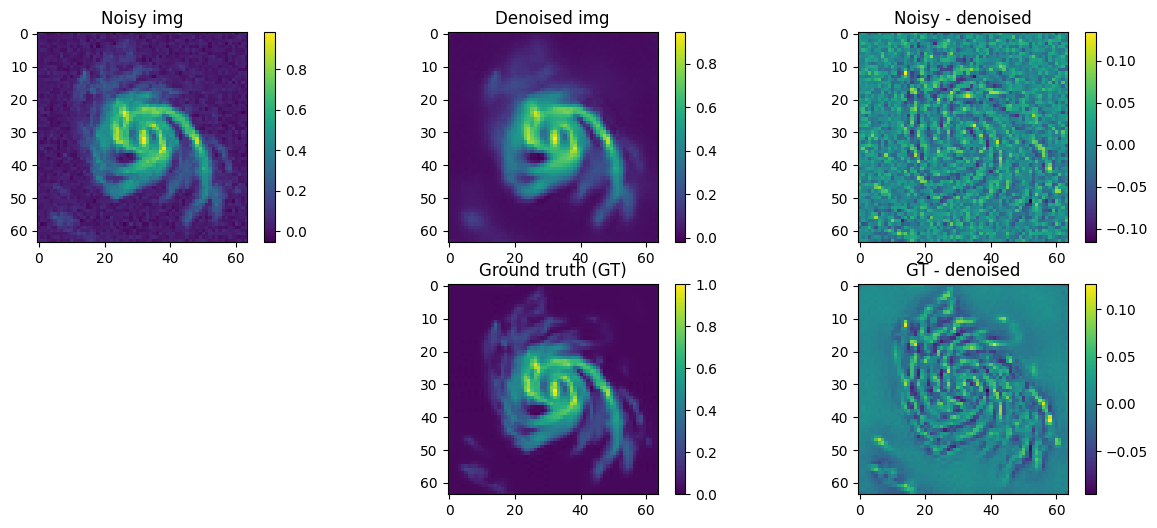

In [51]:


fig = plt.figure(figsize=(15,6))

fig.add_subplot(231)
plt.imshow(y)
plt.colorbar()
plt.title('Noisy img')

fig.add_subplot(232)
plt.imshow(np_denoised_y)
plt.colorbar()
plt.title('Denoised img')

fig.add_subplot(233)
plt.imshow(y - np_denoised_y)
plt.colorbar()
plt.title('Noisy - denoised')

fig.add_subplot(235)
plt.imshow(ground_truth)
plt.colorbar()
plt.title('Ground truth (GT)')

fig.add_subplot(236)
plt.imshow(ground_truth - np_denoised_y)
plt.colorbar()
plt.title('GT - denoised')


plt.show()
